In [ ]:
!nvidia-smi

Mon Oct 28 12:38:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   33C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Check TensorFlow for GPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:

    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("No GPU, TensorFlow uses CPU.")

  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
print(tf.__version__)

2.17.0


In [6]:
import os
import IPython

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import warnings

warnings.filterwarnings('ignore')

In [7]:
output_dir = '/content/drive/MyDrive/DataSet/ML hw'

dataset, info = tfds.load(
    "oxford_iiit_pet",
    data_dir=output_dir,
    with_info=True,
    as_supervised=True,
    download=True,
    shuffle_files=True
)

IPython.display.clear_output()

In [28]:
train_dataset = dataset['train']
test_dataset = dataset['test']

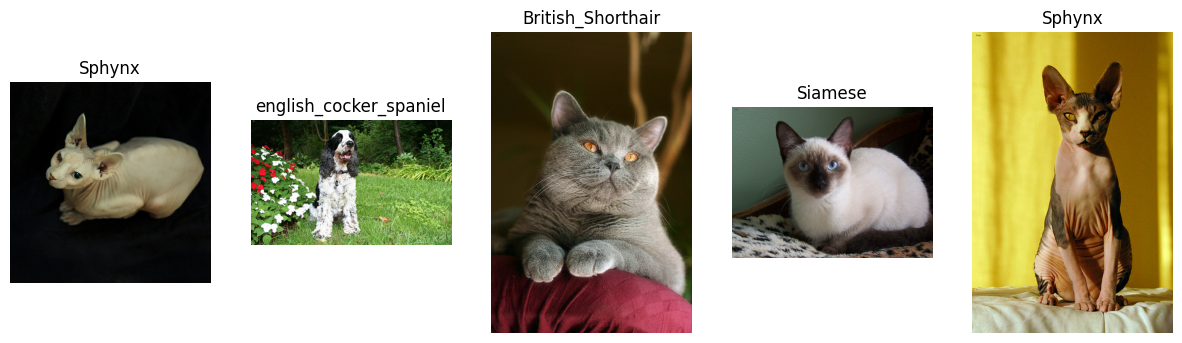

In [13]:
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        class_name = info.features['label'].int2str(label.numpy())
        plt.title(class_name)
        plt.axis('off')
    plt.show()

show_samples(train_dataset, num_samples=5)

In [14]:
image_size = 32
# data augmentation
import random

def augment_image(image, label):
    image = tf.image.resize(image, (image_size, image_size))
    image = tf.cast(image, tf.float32) / 255.0
    # list of augmentation functions
    augmentation_funcs = [
        tf.image.random_brightness,
        tf.image.random_contrast,
        tf.image.random_hue,
        tf.image.random_saturation,
        tf.image.random_flip_left_right,
        tf.image.random_flip_up_down,
        tf.image.random_crop,
        tf.image.random_jpeg_quality,
        tf.image.random_flip_up_down,
        tf.image.random_flip_left_right,
        tf.image.random_saturation,
        tf.image.adjust_brightness,
        tf.image.adjust_contrast,
        tf.image.adjust_gamma,
        tf.image.adjust_hue,
        tf.image.adjust_saturation,
        tf.image.central_crop,
        tf.image.extract_glimpse,
        tf.image.crop_and_resize,
        tf.image.resize_with_crop_or_pad,
        tf.image.rot90,
        tf.image.transpose
    ]

    # Random one augmentation function
    chosen_func = random.choice(augmentation_funcs)

    # Apply augmentation function
    if chosen_func in [tf.image.random_brightness, tf.image.random_contrast,
                       tf.image.random_hue, tf.image.random_saturation,
                       tf.image.adjust_brightness, tf.image.adjust_contrast,
                       tf.image.adjust_gamma, tf.image.adjust_hue,
                       tf.image.adjust_saturation]:

        max_delta = 0.1
        image = chosen_func(image, max_delta=max_delta)
    elif chosen_func == tf.image.random_crop:
        image = tf.image.random_crop(image, size=[image.shape[0] // 2, image.shape[1] // 2, image.shape[2]])
    elif chosen_func in [tf.image.crop_and_resize, tf.image.central_crop]:
        image = tf.image.central_crop(image, central_fraction=0.5)
    elif chosen_func in [tf.image.rot90, tf.image.transpose]:
        image = chosen_func(image)
    else:
        image = chosen_func(image)

    return image, label


In [30]:
repeat_fac = 4
# augment the dataset
train_ds = dataset['train'].repeat(repeat_fac)
train_d = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dr = train_d.prefetch(tf.data.AUTOTUNE)

In [31]:
test_ds = dataset['test'].repeat(repeat_fac)
test_d = test_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dr = test_d.prefetch(tf.data.AUTOTUNE)

In [32]:
def conv2ndarray(tdarray):
    x = []
    y = []
    for xi, label in tdarray:
        x.append(xi)
        y.append(label)
    return np.array(x), np.array(y)

x1, y1 = conv2ndarray(train_dr)
# del train_ds # Remove train_ds, test_ds to clear GPU memory.
x2, y2 = conv2ndarray(test_dr)
# del test_ds # Remove train_ds, test_ds to clear GPU memory.

In [33]:
x1.shape, y1.shape, x2.shape, y2.shape

((14720, 32, 32, 3), (14720,), (14676, 32, 32, 3), (14676,))

In [34]:
x = np.concatenate([x1, x2], axis=0)
# Clear Variable x1, x2,for Memory Space
# del x1
# del x2
y = np.concatenate([y1, y2], axis=0)
# # Clear Variable y1, y2 for Memory Space
# del y1
# del y2

In [35]:
y = tf.keras.utils.to_categorical(y, num_classes=37)
y.shape

(29396, 37)

In [36]:
x.shape, y.shape

((29396, 32, 32, 3), (29396, 37))

In [40]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# # Clear x, y for memory space
# del x
# del y

In [41]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((20577, 32, 32, 3), (20577, 37), (8819, 32, 32, 3), (8819, 37))

In [42]:
model = models.Sequential([

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(y_train.shape[1], activation='softmax')
])

In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [44]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.0628 - loss: 3.4694 - val_accuracy: 0.1488 - val_loss: 3.0730
Epoch 2/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1596 - loss: 3.0326 - val_accuracy: 0.1885 - val_loss: 2.8761
Epoch 3/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2053 - loss: 2.8166 - val_accuracy: 0.2255 - val_loss: 2.7381
Epoch 4/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2659 - loss: 2.5722 - val_accuracy: 0.2575 - val_loss: 2.5911
Epoch 5/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3309 - loss: 2.3353 - val_accuracy: 0.3074 - val_loss: 2.3982
Epoch 6/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3979 - loss: 2.0949 - val_accuracy: 0.3650 - val_loss: 2.2105
Epoch 7/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4527 - loss: 1.8890 - val_accuracy: 0.4158 - val_loss: 2.0327
Epoch 8/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5227 - loss: 1.6415 - val_acc

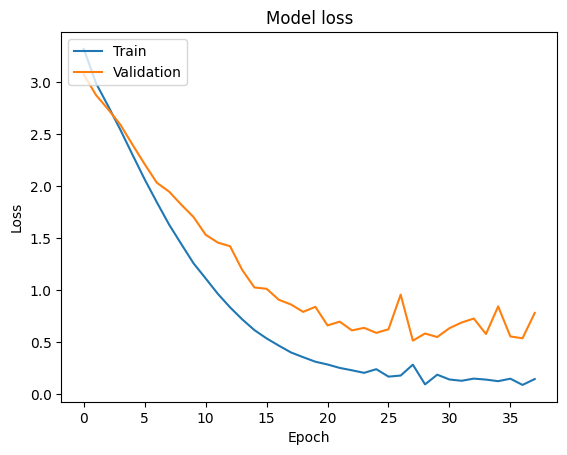

In [45]:

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [46]:
!pip install keras_tuner
IPython.display.clear_output()

In [47]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((20577, 32, 32, 3), (20577, 37), (8819, 32, 32, 3), (8819, 37))

In [48]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt
from keras.callbacks import EarlyStopping


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(32, 32, 3)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'conv_{i+2}_filter', min_value=32, max_value=128, step=16),
            kernel_size=hp.Choice(f'conv_{i+2}_kernel', values=[3, 5]),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ))
    model.add(layers.Dense( y_train.shape[1], activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='/content/drive/MyDrive/DataSet/tune_dir',
    project_name='intro_to_kt'
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

tuner.search(
    x_train, y_train,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of layers is {best_hps.get('n_layers')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Reloading Tuner from /content/drive/MyDrive/DataSet/tune_dir/intro_to_kt/tuner0.json

The optimal number of layers is 1.
The optimal learning rate for the optimizer is 0.0001.



In [ ]:
# !pwd
# %cd /content

In [ ]:
# %cp -r tune_dir /content/drive/MyDrive/DataSet

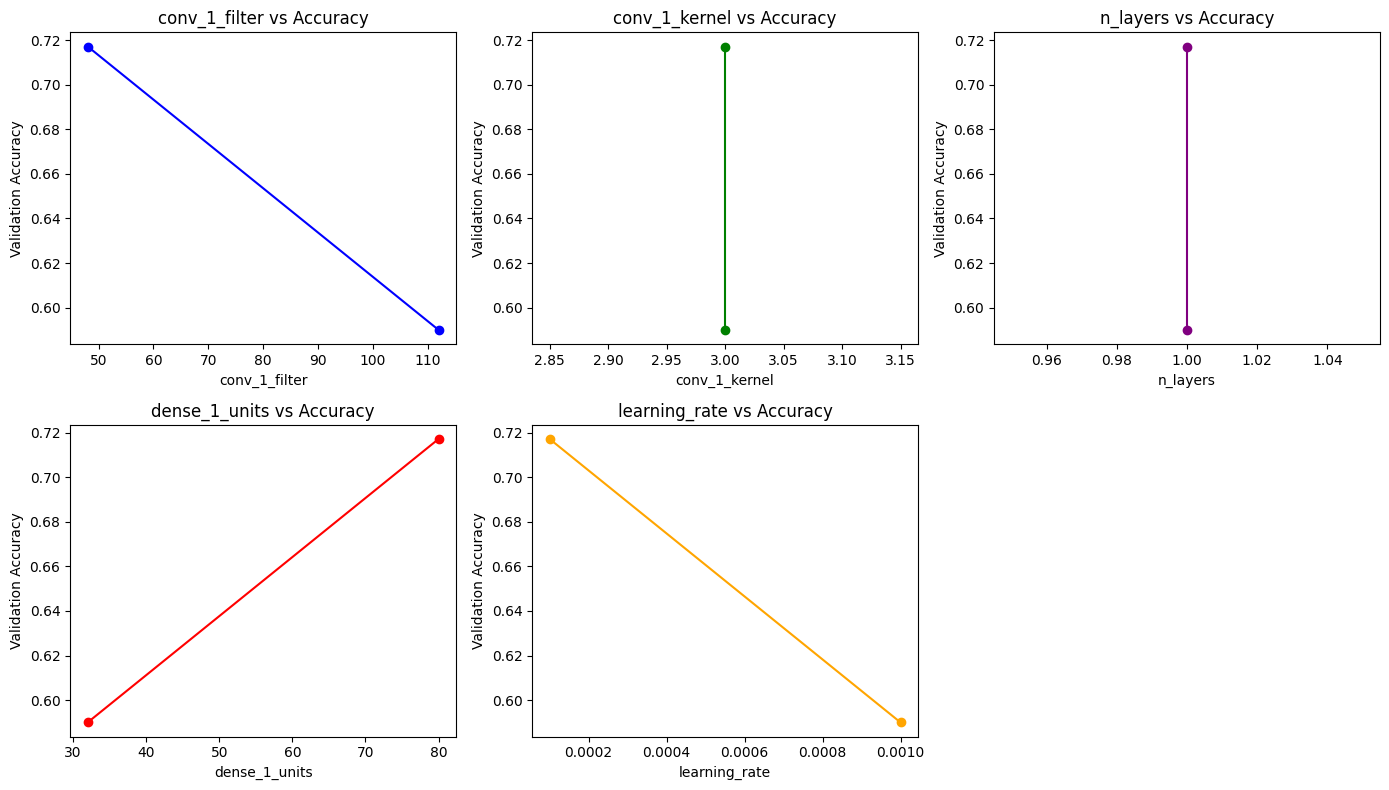

In [49]:
import matplotlib.pyplot as plt

trials = tuner.oracle.get_best_trials(num_trials=5)

trial_data = {
    "trial_id": [],
    "conv_1_filter": [],
    "conv_1_kernel": [],
    "n_layers": [],
    "dense_1_units": [],
    "learning_rate": [],
    "val_accuracy": [],
}

for trial in trials:
    hp_values = trial.hyperparameters.values
    trial_data["trial_id"].append(trial.trial_id)
    trial_data["conv_1_filter"].append(hp_values['conv_1_filter'])
    trial_data["conv_1_kernel"].append(hp_values['conv_1_kernel'])
    trial_data["n_layers"].append(hp_values['n_layers'])
    trial_data["dense_1_units"].append(hp_values['dense_1_units'])
    trial_data["learning_rate"].append(hp_values['learning_rate'])

    if 'val_accuracy' in trial.metrics.metrics:
        best_val_acc = trial.metrics.get_best_value('val_accuracy')
        trial_data["val_accuracy"].append(best_val_acc)
    else:
        trial_data["val_accuracy"].append(None)  # Mark missing values

valid_indices = [i for i, acc in enumerate(trial_data["val_accuracy"]) if acc is not None]
filtered_data = {key: [val[i] for i in valid_indices] for key, val in trial_data.items()}


plt.figure(figsize=(14, 8))

# Plot conv_1_filter
plt.subplot(2, 3, 1)
plt.plot(filtered_data["conv_1_filter"], filtered_data["val_accuracy"], 'o-', color='blue')
plt.xlabel('conv_1_filter')
plt.ylabel('Validation Accuracy')
plt.title('conv_1_filter vs Accuracy')

# Plot conv_1_kernel
plt.subplot(2, 3, 2)
plt.plot(filtered_data["conv_1_kernel"], filtered_data["val_accuracy"], 'o-', color='green')
plt.xlabel('conv_1_kernel')
plt.ylabel('Validation Accuracy')
plt.title('conv_1_kernel vs Accuracy')

# Plot n_layers
plt.subplot(2, 3, 3)
plt.plot(filtered_data["n_layers"], filtered_data["val_accuracy"], 'o-', color='purple')
plt.xlabel('n_layers')
plt.ylabel('Validation Accuracy')
plt.title('n_layers vs Accuracy')

# Plot dense_1_units
plt.subplot(2, 3, 4)
plt.plot(filtered_data["dense_1_units"], filtered_data["val_accuracy"], 'o-', color='red')
plt.xlabel('dense_1_units')
plt.ylabel('Validation Accuracy')
plt.title('dense_1_units vs Accuracy')

# Plot learning_rate
plt.subplot(2, 3, 5)
plt.plot(filtered_data["learning_rate"], filtered_data["val_accuracy"], 'o-', color='orange')
plt.xlabel('learning_rate')
plt.ylabel('Validation Accuracy')
plt.title('learning_rate vs Accuracy')

plt.tight_layout()
plt.show()


In [50]:
# Train Tuning Model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.0453 - loss: 3.5721 - val_accuracy: 0.1026 - val_loss: 3.3274
Epoch 2/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1212 - loss: 3.2685 - val_accuracy: 0.1295 - val_loss: 3.1572
Epoch 3/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1547 - loss: 3.0817 - val_accuracy: 0.1593 - val_loss: 3.0596
Epoch 4/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1858 - loss: 2.9792 - val_accuracy: 0.1847 - val_loss: 2.9471
Epoch 5/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2054 - loss: 2.8948 - val_accuracy: 0.2039 - val_loss: 2.8900
Epoch 6/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2288 - loss: 2.7955 - val_accuracy: 0.2111 - val_loss: 2.8606
Epoch 7/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2530 - loss: 2.7179 - val_accuracy: 0.2198 - val_loss: 2.7916
Epoch 8/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2763 - loss: 2.6308 - val_acc

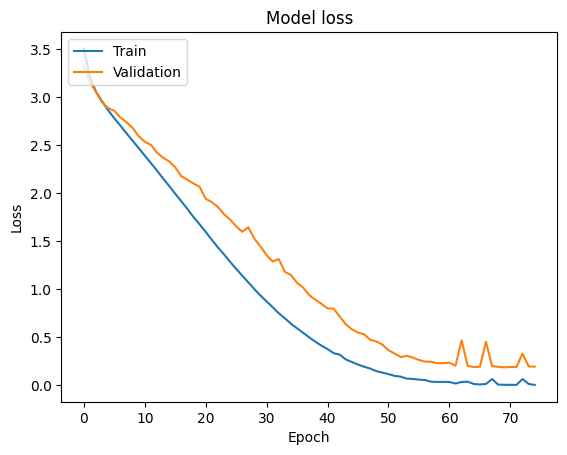

In [51]:
plt.plot(best_model.history.history['loss'])
plt.plot(best_model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for both models (before and after tuning)
y_pred_before = model.predict(x_test)
y_pred_before = np.argmax(y_pred_before, axis=1)
y_true = np.argmax(y_test, axis=1)


y_pred_after = best_model.predict(x_test)
y_pred_after = np.argmax(y_pred_after, axis=1)


# Calculate confusion matrices
cm_before = confusion_matrix(y_true, y_pred_before)
cm_after = confusion_matrix(y_true, y_pred_after)

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


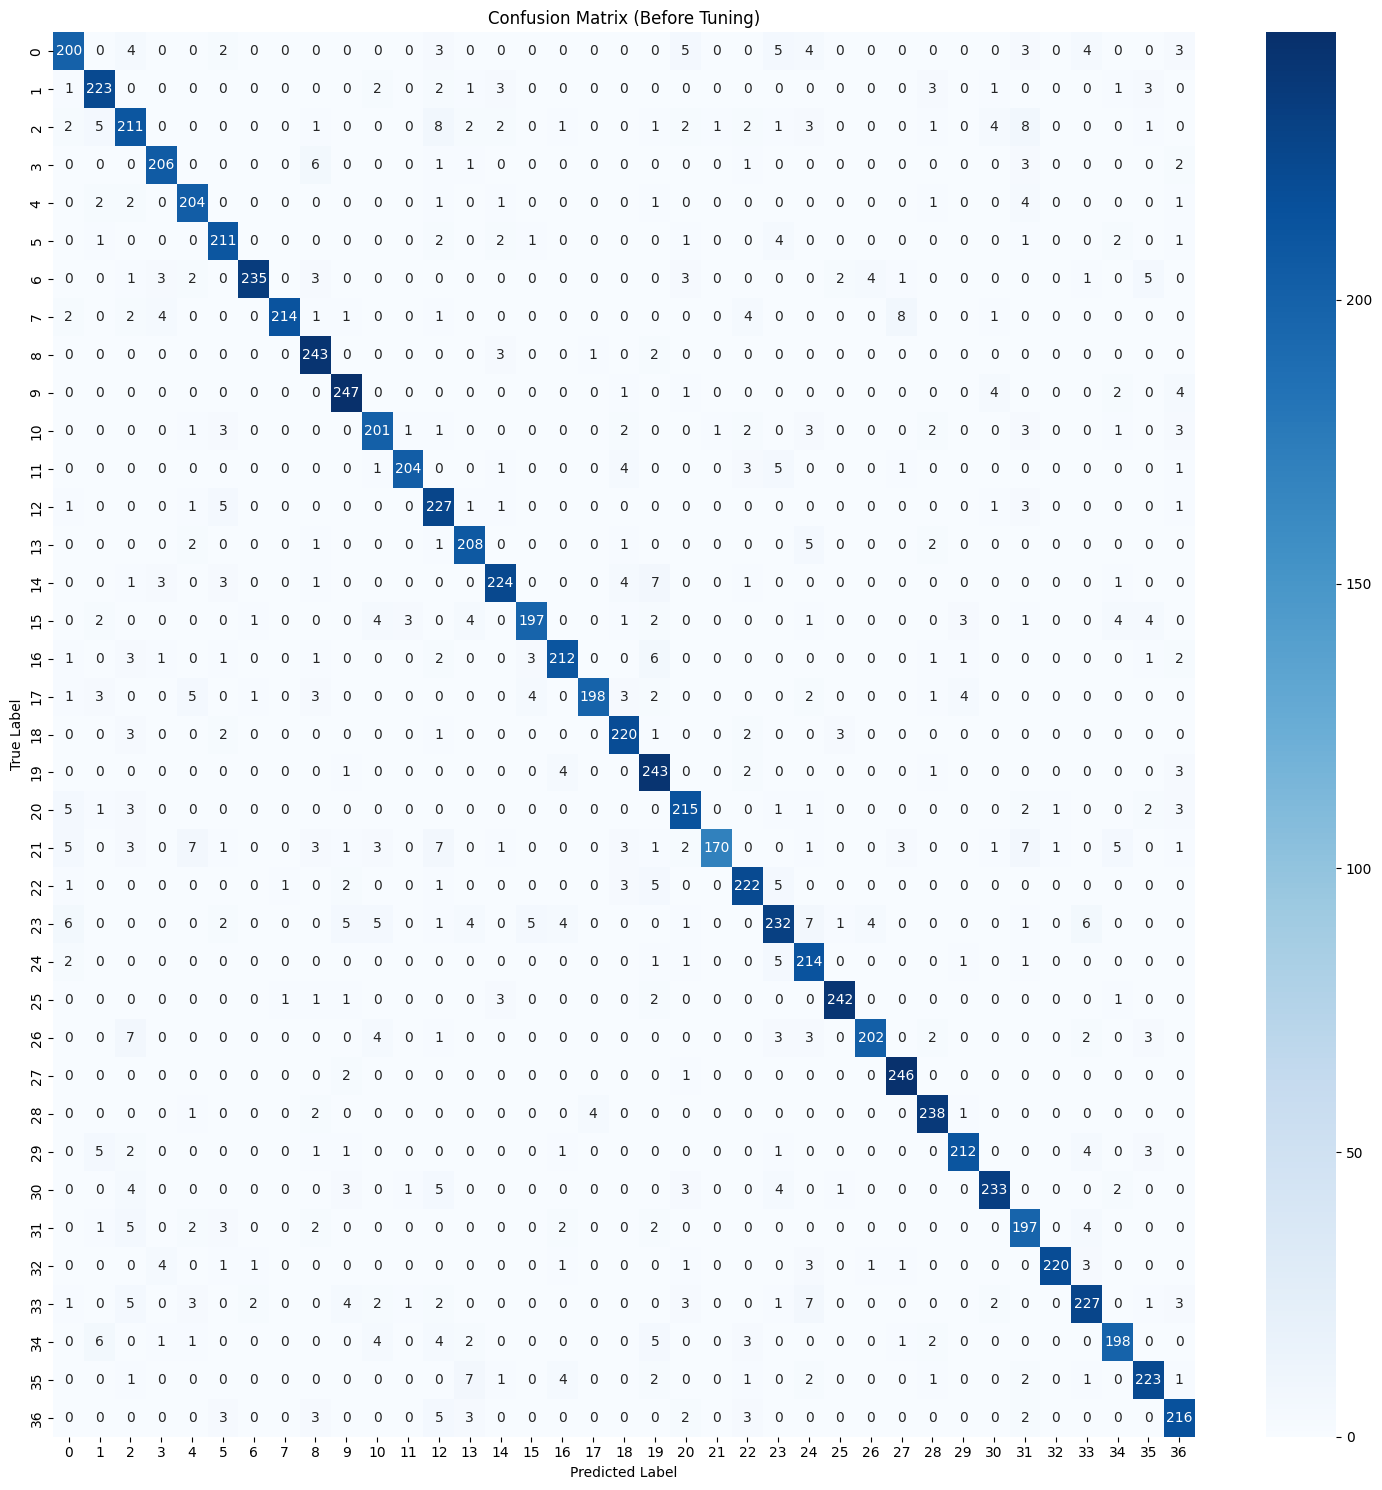

In [53]:
# Plotting confusion matrices before Tune
plt.figure(figsize=(15, 15))

sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Before Tuning)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


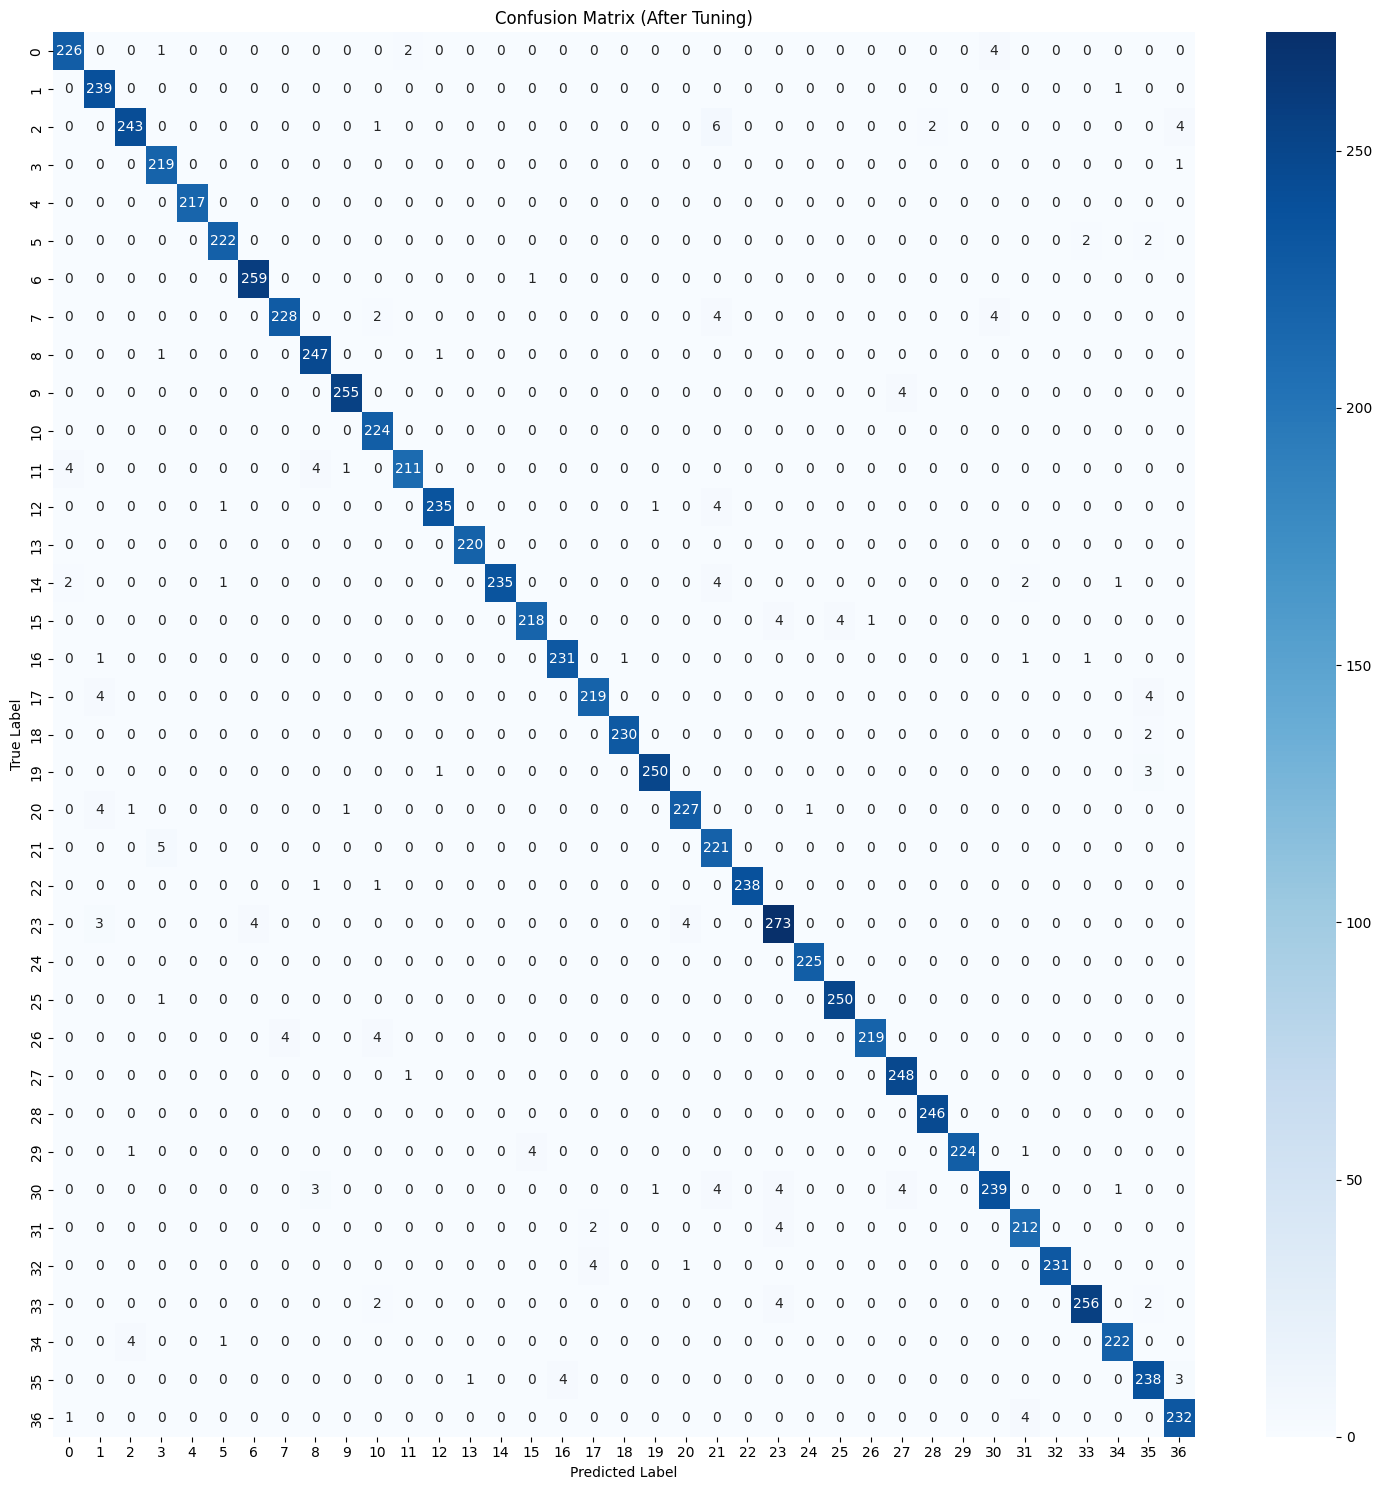

In [54]:
# After Tune Confusion Matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (After Tuning)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [55]:
# Before Tune Classification Report
from sklearn.metrics import classification_report

y_pred_before = model.predict(x_test)
y_pred_before = np.argmax(y_pred_before, axis=1)
y_true = np.argmax(y_test, axis=1)
report_before = classification_report(y_true, y_pred_before)


print("Classification Report (Before Tuning)\n")
print(report_before)

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report (Before Tuning)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       233
           1       0.90      0.93      0.91       240
           2       0.82      0.82      0.82       256
           3       0.93      0.94      0.93       220
           4       0.89      0.94      0.91       217
           5       0.89      0.93      0.91       226
           6       0.98      0.90      0.94       260
           7       0.99      0.90      0.94       238
           8       0.89      0.98      0.93       249
           9       0.92      0.95      0.94       259
          10       0.89      0.90      0.89       224
          11       0.97      0.93      0.95       220
          12       0.82      0.94      0.88       241
          13       0.89      0.95      0.92       220
          14       0.93      0.91      0.92       245
          15       0.94      0.87      0.90       227
 

In [56]:
# After Tune Classification Report
y_pred_after = best_model.predict(x_test)
y_pred_after = np.argmax(y_pred_after, axis=1)
report_after = classification_report(y_true, y_pred_after)
print("\nClassification Report (After Tuning)\n")
print(report_after)

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report (After Tuning)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       233
           1       0.95      1.00      0.97       240
           2       0.98      0.95      0.96       256
           3       0.96      1.00      0.98       220
           4       1.00      1.00      1.00       217
           5       0.99      0.98      0.98       226
           6       0.98      1.00      0.99       260
           7       0.98      0.96      0.97       238
           8       0.97      0.99      0.98       249
           9       0.99      0.98      0.99       259
          10       0.96      1.00      0.98       224
          11       0.99      0.96      0.97       220
          12       0.99      0.98      0.98       241
          13       1.00      1.00      1.00       220
          14       1.00      0.96      0.98       245
          15       0.98      0.96      0.97       227
 

In [57]:
# Evaluation Matrix before Tune and After Tune
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_before = accuracy_score(y_true, y_pred_before)
precision_before = precision_score(y_true, y_pred_before, average='weighted')
recall_before = recall_score(y_true, y_pred_before, average='weighted')
f1_before = f1_score(y_true, y_pred_before, average='weighted')

accuracy_after = accuracy_score(y_true, y_pred_after)
precision_after = precision_score(y_true, y_pred_after, average='weighted')
recall_after = recall_score(y_true, y_pred_after, average='weighted')
f1_after = f1_score(y_true, y_pred_after, average='weighted')

evaluation_matrix = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Before Tuning': [accuracy_before, precision_before, recall_before, f1_before],
    'After Tuning': [accuracy_after, precision_after, recall_after, f1_after]
})

evaluation_matrix

,Metric,Before Tuning,After Tuning
0,Accuracy,0.911101,0.978456
1,Precision,0.913527,0.978789
2,Recall,0.911101,0.978456
3,F1-Score,0.911055,0.978483


In [59]:
# best_model.save('/content/drive/MyDrive/DataSet/Model/best_cnn_model.keras')

In [85]:
def show_true_false_pred(x_test, y_test, y_pred, class_names, num_samples=5):
    """
    Shows random images with their true and predicted labels, ensuring at least one incorrect prediction is displayed.

    Args:
        x_test: Test data (images).
        y_test: True labels.
        y_pred: Predicted labels.
        class_names: List of class names.
        num_samples: Number of samples to display.
    """
    if x_test.max() <= 1.0:
        x_test = (x_test * 255).astype(np.uint8)

    incorrect_indices = np.where(y_test != y_pred)[0]
    correct_indices = np.where(y_test == y_pred)[0]

    display_indices = np.random.choice(incorrect_indices, min(len(incorrect_indices), 1), replace=False).tolist()

    if len(display_indices) < num_samples:
        remaining_indices = np.random.choice(
            len(x_test),
            num_samples - len(display_indices),
            replace=False
        )
        display_indices.extend(remaining_indices)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(display_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[idx])
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", color="green" if y_test[idx] == y_pred[idx] else "red")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

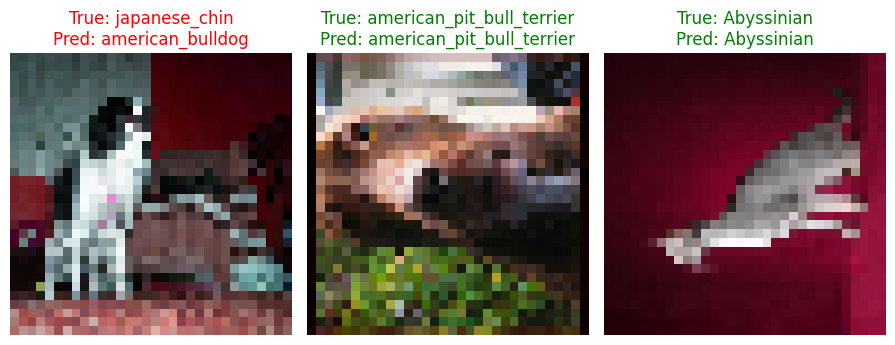

In [87]:
# call function
class_names = info.features['label'].names
nums = 3
show_true_false_pred(x_test, np.argmax(y_test, axis=1), y_pred_after, class_names, num_samples=nums)

# Compareision Model CNN and RestNet

In [88]:
import tensorflow as tf
restnet = tf.keras.models.load_model('/content/drive/MyDrive/DataSet/Model/best_RestNet.h5')

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


<Figure size 1000x800 with 0 Axes>

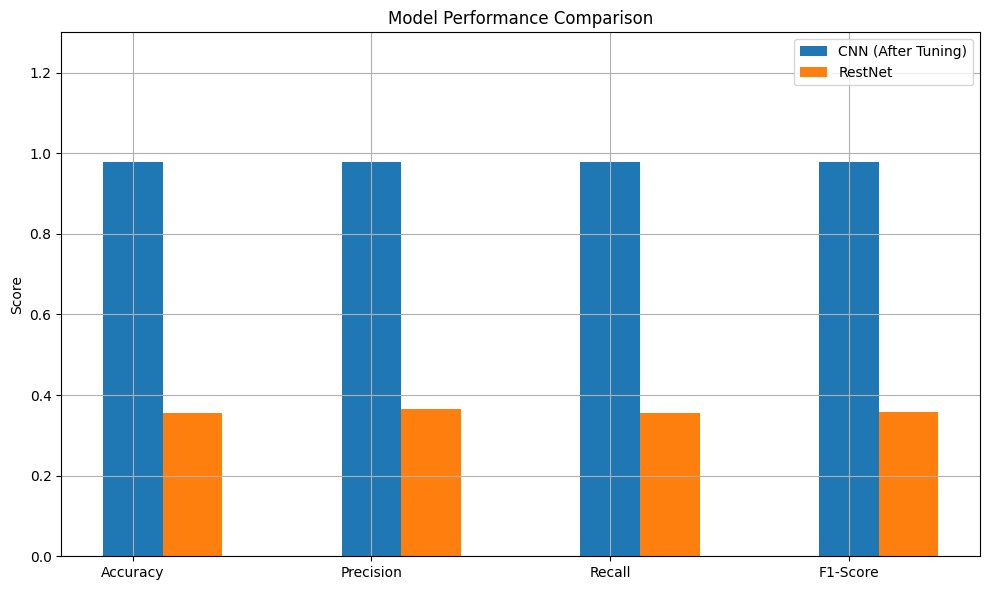

In [96]:
# Get predictions for Restnet
y_pred_restnet = restnet.predict(x_test)
y_pred_restnet = np.argmax(y_pred_restnet, axis=1)

# evaluation metrics for Restnet
accuracy_restnet = accuracy_score(y_true, y_pred_restnet)
precision_restnet = precision_score(y_true, y_pred_restnet, average='weighted')
recall_restnet = recall_score(y_true, y_pred_restnet, average='weighted')
f1_restnet = f1_score(y_true, y_pred_restnet, average='weighted')

# Create a DataFrame for comparison
model_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'CNN (After Tuning)': [accuracy_after, precision_after, recall_after, f1_after],
    'RestNet': [accuracy_restnet, precision_restnet, recall_restnet, f1_restnet]
})

metrics = model_comparison['Metric'].tolist()
cnn_after = model_comparison['CNN (After Tuning)'].tolist()
resnet = model_comparison['RestNet'].tolist()

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10, 8))
fig, ax = plt.subplots(figsize=(10, 6))
rects2 = ax.bar(x, cnn_after, width, label='CNN (After Tuning)')
rects3 = ax.bar(x + width, resnet, width, label='RestNet')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0, 1.3)
fig.tight_layout()
plt.grid()
plt.show()


In [97]:
model_comparison

,Metric,CNN (After Tuning),RestNet
0,Accuracy,0.978456,0.355709
1,Precision,0.978789,0.364739
2,Recall,0.978456,0.355709
3,F1-Score,0.978483,0.357413
